In [1]:
import numpy as np
import pandas as pd
from utils import misc
from utils.misc import get_attr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from new_agent import DQNagent
from new_env import TradingEnv
from trainer import Trainer

import optuna

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


pd.set_option('mode.chained_assignment', None)

In [3]:
df = misc.get_price_data('SPY')
# df = misc.clean_df(df)
df.to_csv('datasets/price_series/SPY.csv')

In [4]:
spy_df = pd.read_csv('datasets/price_series/SPY.csv')
spy_df = misc.clean_df(spy_df)
spy_df

,date,open,high,low,close,adjclose,volume,ticker
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,25.029379,1003200,SPY
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.207388,480500,SPY
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,25.260792,201300,SPY
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,25.527826,529400,SPY
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,25.634638,531500,SPY
...,...,...,...,...,...,...,...,...
7679,2023-07-31,457.410004,458.160004,456.049988,457.790009,457.790009,62040400,SPY
7680,2023-08-01,456.269989,457.250000,455.489990,456.480011,456.480011,55291500,SPY
7681,2023-08-02,453.250000,453.519989,449.350006,450.130005,450.130005,93933400,SPY
7682,2023-08-03,448.040009,450.790009,447.369995,448.839996,448.839996,64276100,SPY


In [3]:
df = spy_df.copy()

# generate moving average technical indicator
col_names = []
for i in range(3, 21):
    col_name = 'ma' + str(i)
    df[col_name] = df['close'].rolling(i).mean()
    col_names.append(col_name)

df['returns'] = np.insert(df['close'].to_numpy()[1:] / df['close'].to_numpy()[:-1], 1, 0) - 1
df['volatility'] = df['returns'].rolling(30).std()

df = df.dropna()
df



,date,open,high,low,close,adjclose,volume,ticker,ma3,ma4,...,ma13,ma14,ma15,ma16,ma17,ma18,ma19,ma20,returns,volatility
29,1993-03-12,45.187500,45.218750,44.812500,45.093750,25.881849,643600,SPY,45.447917,45.484375,...,44.973558,44.881696,44.804167,44.726562,44.648897,44.581597,44.523026,44.526562,-0.010288,0.182937
30,1993-03-15,45.062500,45.312500,45.062500,45.312500,26.007406,310800,SPY,45.322917,45.414062,...,45.055288,44.997768,44.910417,44.835938,44.761029,44.685764,44.620066,44.562500,0.004851,0.182920
31,1993-03-16,45.312500,45.437500,45.312500,45.312500,26.007406,30800,SPY,45.239583,45.320312,...,45.129808,45.073661,45.018750,44.935547,44.863971,44.791667,44.718750,44.654688,0.000000,0.008342
32,1993-03-17,45.250000,45.250000,44.968750,45.031250,25.845985,21800,SPY,45.218750,45.187500,...,45.177885,45.122768,45.070833,45.019531,44.941176,44.873264,44.804276,44.734375,-0.006207,0.008435
33,1993-03-18,45.218750,45.500000,45.218750,45.312500,26.007406,59300,SPY,45.218750,45.242188,...,45.257212,45.187500,45.135417,45.085938,45.036765,44.961806,44.896382,44.829687,0.006246,0.008294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7581,2023-03-09,399.739990,401.480011,390.529999,391.559998,391.559998,111945300,SPY,396.250000,398.305000,...,398.355387,398.991431,399.610669,400.508753,401.222356,401.867225,402.192108,402.437003,-0.018450,0.010437
7582,2023-03-10,390.989990,393.160004,384.320007,385.910004,385.910004,189105300,SPY,392.130005,393.665001,...,397.341541,397.466431,398.119336,398.754377,399.650003,400.371670,401.027371,401.378003,-0.014429,0.010488
7583,2023-03-13,381.809998,390.390015,380.649994,385.359985,385.359985,157790000,SPY,387.609996,390.437500,...,396.327693,396.485716,396.659334,397.321877,397.966472,398.856113,399.581582,400.244002,-0.001425,0.010463
7584,2023-03-14,390.500000,393.450012,387.049988,391.730011,391.730011,149752400,SPY,387.666667,388.639999,...,395.640771,395.999287,396.168669,396.351252,396.992943,397.620002,398.481055,399.189003,0.016530,0.010763


In [4]:
class DQN(nn.Module):
    
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    

In [5]:
input_feature_list = [
    'open',
    'high',
    'low',
    'close',
    'adjclose',
    'volume',
    'volatility',
]

input_feature_list += col_names

trader_state_list = [
    'cash',
    'position',
    'position_value',
    'portfolio_value',
    # 'leverage',
    # 'portfolio_volatility',
]

params = {
    # agent params
    'action_size': 9,
    'state_size': len(input_feature_list) + len(trader_state_list),
    'epsilon': 1.0,
    'epsilon_decay': 0.9995,
    'epsilon_min': 0.01,
    'replay_memory_size': 100000,
    'batch_size': 200,
    'gamma': 0.99,
    'new_model': True,
    'save_model_path': 'dqn.pth',
    'load_model_path': 'dqn.pth',
    # env_params
    'initial_capital': 1000000,
    'hindsight_weight': 0.5,
    'lookback_period': 20,
    'lookforward_period': 20,
    'render_window_size': 10,
    'input_feature_list': input_feature_list,
    # trainer_params
    'num_episodes': 20,
    'record_var_list': ['portfolio_return'],
    'learning_rate': 0.001,
    'target_update_threshold': 10,
}

train_df = df[-500:-100]
test_df = df[-100:]

train_env = TradingEnv(df=train_df, **params)
test_env = TradingEnv(df=test_df, **params)

agent = DQNagent(DQN, **params)

c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


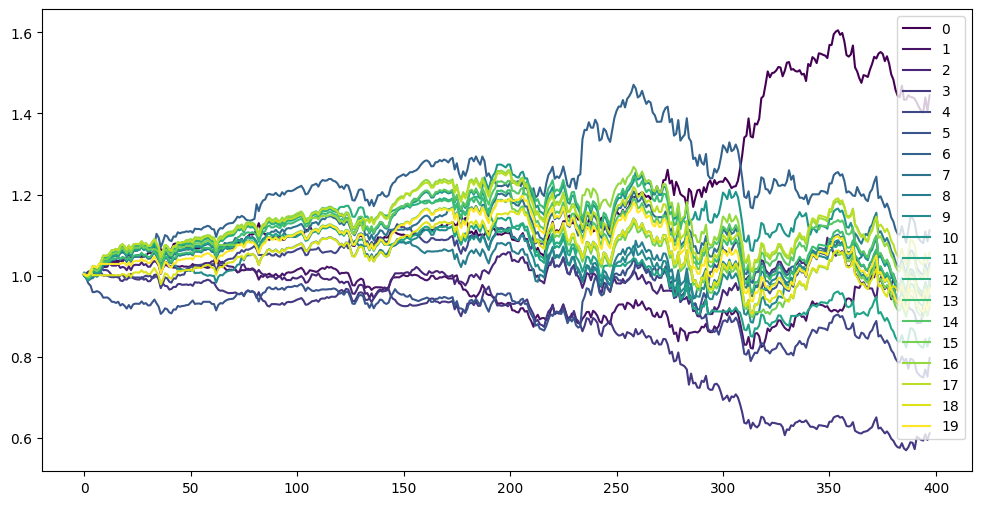

In [6]:
trainer = Trainer(agent=agent, **params)

record, trade_record = trainer.train(train_df)

plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 20))

for r in range(len(record)):
    plt.plot(record[r]['portfolio_return'], label=r, color=colors[r])

plt.legend()
plt.show()

In [7]:
# Define the objective function to be optimized by Optuna
def objective(trial):
    params = {
        # agent params
        'action_size': 9,
        'state_size': len(input_feature_list) + len(trader_state_list),
        'epsilon': 1.0,
        'epsilon_decay': trial.suggest_float('epsilon_decay', 0.8, 0.9995),
        'epsilon_min': trial.suggest_float('epsilon_min', 0.005, 0.05),
        'replay_memory_size': trial.suggest_int('replay_memory_size', 1000, 100000),
        'batch_size': trial.suggest_int('batch_size', 100, 1000),
        'gamma': trial.suggest_float('gamma', 0.01, 0.99),
        'new_model': True,
        'save_model_path': 'dqn.pth',
        'load_model_path': 'dqn.pth',
        # env_params
        'initial_capital': 1000000,
        'hindsight_weight': trial.suggest_float('hindsight_weight', 0.1, 1.0),
        'lookback_period': 20,
        'lookforward_period': 20,
        'render_window_size': 10,
        'input_feature_list': input_feature_list,
        # trainer_params
        'num_episodes': 10,
        'record_var_list': ['portfolio_return'],
        'learning_rate': trial.suggest_float('learning_rate', 0.0005, 0.1),
        'target_update_threshold': 9,
    }

    # Train the model using the current set of hyperparameters
    obj_agent = DQNagent(DQN, **params)
    obj_trainer = Trainer(obj_agent, **params)
    obj_trainer.train(train_df)
    obj_env = obj_trainer.test(test_df)

    # Compute the validation loss
    score = obj_env.sharpe

    return score

# Create the Optuna study
study = optuna.create_study(direction='maximize')

# Run the optimization
study.optimize(objective, n_trials=50)

[I 2023-08-03 15:30:57,758] A new study created in memory with name: no-name-20ec8b09-c20f-4bab-b142-7a6ad0615e46
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alexr\miniconda3\envs\Trade

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alexr\miniconda3\envs\Trade

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alexr\miniconda3\envs\Trade

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
[W 2023-08-03 15:31:57,623] Trial 3 failed with parameters: {'epsilon_decay': 0.933010540888973, 'epsilon_min': 0.04758746137577955, 'replay_memory_size': 23594, 'batch_size': 881, 'gamma': 0.32701791913928857, 'hindsight_weight': 0.39632792152878726, 'learning_rate': 0.019144510431833406} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\alexr\

KeyboardInterrupt: 

In [ ]:
# Print the best set of hyperparameters
print(f'Best trial: {study.best_trial.params}')

Best trial: {'epsilon_decay': 0.8306813359067265, 'epsilon_min': 0.01444127970152943, 'replay_memory_size': 19639, 'batch_size': 571, 'gamma': 0.631254580290752, 'hindsight_weight': 0.6764271893051359, 'learning_rate': 0.011191048800987747}


In [ ]:
best_trial = {
    'epsilon_decay': 0.8306813359067265, 
    'epsilon_min': 0.01444127970152943, 
    'replay_memory_size': 19639, 
    'batch_size': 571, 
    'gamma': 0.631254580290752, 
    'hindsight_weight': 0.6764271893051359, 
    'learning_rate': 0.011191048800987747
}